In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms

In [2]:
train_data_path = 'C:\\DATA\\Covid19-dataset\\train'
test_data_path = 'C:\\DATA\\Covid19-dataset\\test'

In [3]:
train_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                       transforms.RandomHorizontalFlip(), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize((224, 224)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

In [4]:
train_data = torchvision.datasets.ImageFolder(root = train_data_path, transform = train_transforms)
test_data = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)

In [5]:
len(train_data), len(test_data)

(251, 66)

In [6]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size = 16, shuffle = True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size = 8, shuffle = False)

In [7]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [8]:
X_batch, y_batch = next(iter(train_dataloader))

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

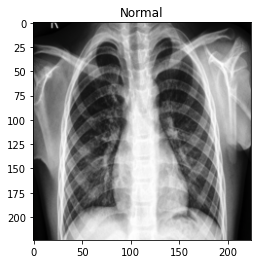

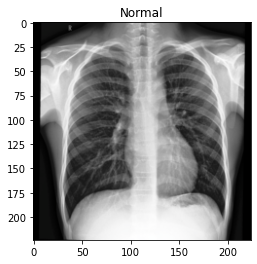

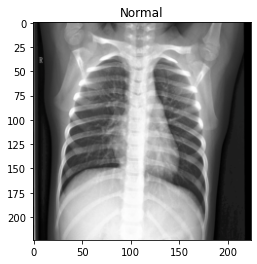

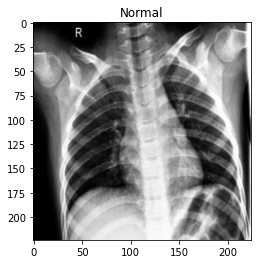

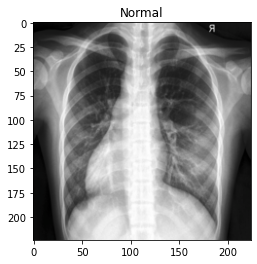

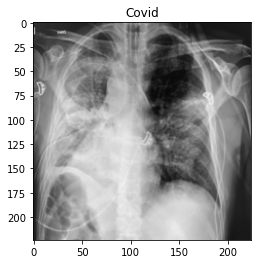

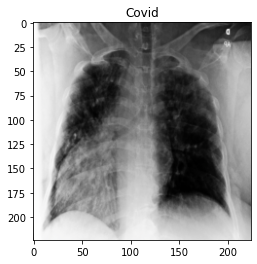

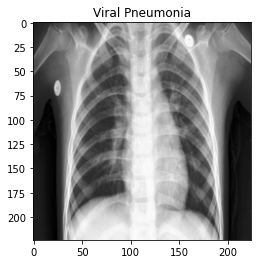

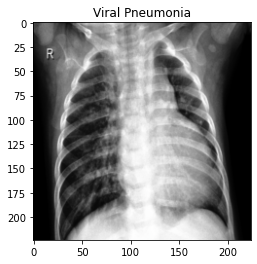

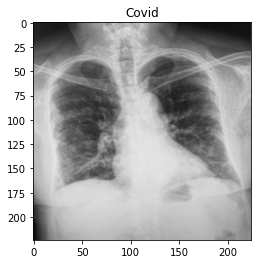

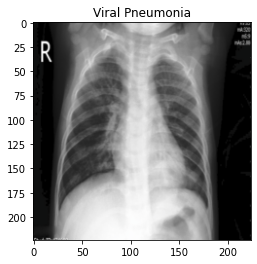

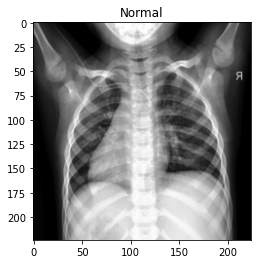

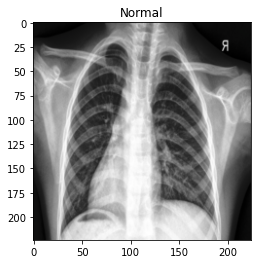

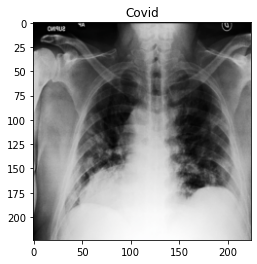

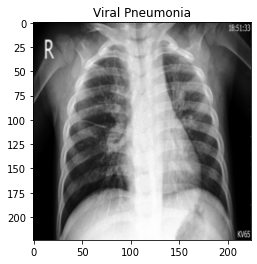

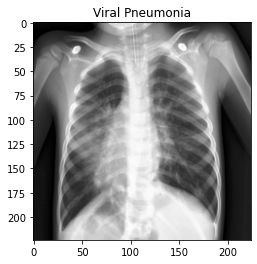

In [10]:
class_names = ['Covid', 'Normal', 'Viral Pneumonia']
for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [11]:
model = torchvision.models.resnet50(pretrained = True)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
for param in model.parameters():
    param.requires_grad = False

In [14]:
model.fc = torch.nn.Linear(model.fc.in_features, 3)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
model = model.to(device)

In [17]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad = True, lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, n_epochs):
    
    train_loss = []
    val_loss = []
    val_acc = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_acc = []
        
        model.train()
        
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            optimizer.step()
            ep_train_loss.append(loss.item())
            
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                predictions = model(X_batch)
                loss = loss_fn(predictions, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = predictions.max(1)[1].data
                ep_val_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
                
        print(f'Epoch {epoch + 1} of {n_epochs}')
        
        scheduler.step()
        
        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_acc.append(np.mean(ep_val_acc))
        
        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t validation loss: {val_loss[-1]:.6f}")
        print(f"\t validation accuracy: {val_acc[-1]:.3f}")
        
    return train_loss, val_loss, val_acc

In [19]:
def plot_train_process(train_loss, val_loss, val_acc):
    fig, axes = plt.subplots(1, 2, figsize = (15,5))
    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label = 'train')
    axes[0].plot(val_loss, label = 'validation')
    axes[0].legend()
    axes[1].set_title('Validation accuracy')
    axes[1].plot(val_acc)

In [20]:
train_loss, val_loss, val_acc = train_model(model, train_dataloader, test_dataloader, loss, optimizer, 30)

Epoch 1 of 30
	 training loss: 0.967475
	 validation loss: 0.818622
	 validation accuracy: 0.625
Epoch 2 of 30
	 training loss: 0.559634
	 validation loss: 0.605754
	 validation accuracy: 0.750
Epoch 3 of 30
	 training loss: 0.462140
	 validation loss: 0.435241
	 validation accuracy: 0.833
Epoch 4 of 30
	 training loss: 0.381949
	 validation loss: 0.426586
	 validation accuracy: 0.819
Epoch 5 of 30
	 training loss: 0.371849
	 validation loss: 0.380525
	 validation accuracy: 0.875
Epoch 6 of 30
	 training loss: 0.279714
	 validation loss: 0.348299
	 validation accuracy: 0.903
Epoch 7 of 30
	 training loss: 0.246080
	 validation loss: 0.350924
	 validation accuracy: 0.833
Epoch 8 of 30
	 training loss: 0.248931
	 validation loss: 0.325328
	 validation accuracy: 0.889
Epoch 9 of 30
	 training loss: 0.225091
	 validation loss: 0.319451
	 validation accuracy: 0.917
Epoch 10 of 30
	 training loss: 0.195717
	 validation loss: 0.314026
	 validation accuracy: 0.917
Epoch 11 of 30
	 training los

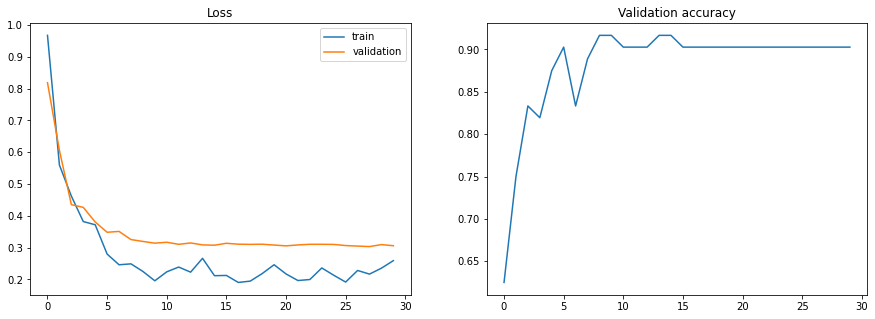

In [21]:
plot_train_process(train_loss, val_loss, val_acc)